### Notebook for the label transfer of Healthy Human Cell Atlas leucocytes to mouse ACM heart (merged Pkp2+Ttn dataset) using `scANVI`

#### Environment: scANVI

- **Developed by:** Carlos Talavera-López Ph.D
- **Modified by:** Alexandra Cirnu
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- **Date of creation:** 230918
- **Date of modification:** 240308

Perform seed label transfer of HCA leucocytes which was subsetted to contain only 15000 HVGs to ACM data set 

### Import required modules

In [197]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker

### Set up working environment

In [198]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
PIL                 10.2.0
absl                NA
array_api_compat    1.4.1
asttokens           NA
attr                23.2.0
chex                0.1.85
colorama            0.4.6
comm                0.2.1
contextlib2         NA
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0
debugpy             1.8.1
decorator           5.1.1
docrep              0.3.2
etils               1.7.0
exceptiongroup      1.2.0
executing           2.0.1
flax                0.8.1
fsspec              2024.2.0
h5py                3.10.0
igraph              0.11.4
importlib_resources NA
ipykernel           6.29.3
ipywidgets          8.1.2
jax                 0.4.25
jaxlib              0.4.25
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
lightning           2.1.4
lightning_utilities 0.10.1
llvmlite            0.42.0
matplotlib          3.8.3
matplotlib_inline   0.1.6
mizani              0.11.0
ml_colle

In [199]:
def X_is_raw(adata): return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

In [200]:
torch.set_float32_matmul_precision('high')

In [201]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

Seed set to 1712


In [202]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

### Read in Healthy data

In [203]:
#Human_Cell_Atlas_Cardiac_leucocytes_from_healthy_human_donors (cell_states were merged into more general cell types and stored in 'seed_lables', 15000 HVGs were selected)

reference = sc.read_h5ad('/home/acirnu/data/ACM_cardiac_leuco/Reference_data/HCA_all_celltypes_healthy_reference_HVG15000_ac240308.raw.h5ad')
reference

AnnData object with n_obs × n_vars = 40868 × 15000
    obs: 'NRP', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'region', 'sample', 'scNym', 'scNym_confidence', 'seed_labels'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'cell_states_colors', 'hvg', 'scNym_colors', 'scNym_probabilities'
    obsm: 'X_pca', 'X_scnym', 'X_umap'
    layers: 'counts'

In [204]:
X_is_raw(reference)

True

In [205]:
reference.obs['seed_labels'].value_counts()                             #seed_labels, that we want to transfer to unannotated data set

seed_labels
Macrophages    14519
Monocytes       6845
CD8+T           5957
CD4+T           4160
NK              3628
Mast_cells      1543
NKT             1463
B_cells         1195
DC               814
Doublets         623
Neutrophils      121
Name: count, dtype: int64

In [206]:
reference.obs['seed_labels'].cat.categories

Index(['B_cells', 'CD4+T', 'CD8+T', 'DC', 'Doublets', 'Macrophages',
       'Mast_cells', 'Monocytes', 'NK', 'NKT', 'Neutrophils'],
      dtype='object')

### Subset populations of interest

In [207]:
reference = reference[~reference.obs['seed_labels'].isin(['nan'])]              # = filter out not assigned cells, keep everything that is not 'nan'
reference.obs['seed_labels'].value_counts()

seed_labels
Macrophages    14519
Monocytes       6845
CD8+T           5957
CD4+T           4160
NK              3628
Mast_cells      1543
NKT             1463
B_cells         1195
DC               814
Doublets         623
Neutrophils      121
Name: count, dtype: int64

In [208]:
sc.pp.filter_cells(reference, min_genes = 200)              #to remove empty cells from table
sc.pp.filter_cells(reference, min_counts = 100)

filtered out 19 cells that have less than 200 genes expressed


### Read in query

In [209]:
#Merged Pkp2+Ttn Libraries subsetted to contain only control mice (Pkp_Ctr_noninf and Ttn_Ctr_noninf)

query = sc.read_h5ad('/home/acirnu/data/ACM_cardiac_leuco/processed_merged/Merge+Subset_Ctrls_demux_QCed_ac240221.raw.h5ad')
query.obs['cell_source'] = 'AG_Gerull'
query.obs['seed_labels'] = 'Unknown'
query.obs['donor'] = query.obs['sample'].copy()
query

AnnData object with n_obs × n_vars = 7847 × 32285
    obs: 'sample', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'cell_source', 'seed_labels', 'donor'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B2', 'pct_dropout_by_counts-B2', 'total_counts-B2'
    layers: 'counts', 'sqrt

In [210]:
X_is_raw(query)

True

In [211]:
sc.pp.filter_cells(query, min_genes = 200)
sc.pp.filter_cells(query, min_counts = 100)

### Change gene symbols for label transfer

In [212]:
query.var_names = [gene_name.upper() for gene_name in query.var_names]                      #capitalize gene names to match with the human genes from reference
query.var_names

Index(['XKR4', 'GM1992', 'GM19938', 'GM37381', 'RP1', 'SOX17', 'GM37587',
       'GM37323', 'MRPL15', 'LYPLA1',
       ...
       'GM16367', 'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2',
       'AC124606.1', 'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1'],
      dtype='object', length=32285)

### Merge reference and query data set

In [213]:
adata = reference.concatenate(query, batch_key = 'batch', batch_categories = ['reference', 'query'], join = 'inner')                #merge to one adata object
adata

AnnData object with n_obs × n_vars = 48696 × 9438
    obs: 'NRP', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'region', 'sample', 'scNym', 'scNym_confidence', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-A1-query', 'mean_counts-A1-query', 'pct_dropout_by_counts-A1-query', 'total_counts-A1-query', 'n_cells_by_counts-A2-query', 'mean_counts-A2-query', 'pct_dropout_by_counts-A2-query', 'total_counts-A2-query', 'n_cells_by_counts-A3-query', 'mean_counts-A3-query', 'pct_dropout_by_counts-A3-query', 'total_counts-A3-query', 'n_cells_by_counts-A4-query', 'mean_counts-A4-query', 'pct_dropout_by_counts-A4-query', 'total_counts-A4-query', 'n_c

In [214]:
adata.obs['seed_labels'] = adata.obs['seed_labels'].astype('category')
adata.obs['seed_labels'].cat.categories

Index(['B_cells', 'CD4+T', 'CD8+T', 'DC', 'Doublets', 'Macrophages',
       'Mast_cells', 'Monocytes', 'NK', 'NKT', 'Neutrophils', 'Unknown'],
      dtype='object')

In [215]:
adata.obs['batch'].value_counts()

batch
reference    40849
query         7847
Name: count, dtype: int64

### Select HVGs

In [216]:
adata.obs['donor'] = adata.obs['donor'].astype('str') 
adata.obs['donor'].value_counts()

donor
D6                   9355
D7                   8456
D11                  5635
H2                   2655
D3                   2118
D2                   2033
H3                   1965
Ttn_Ctr_noninf_1     1821
H7                   1799
Pkp2_Ctr_noninf_2    1649
Ttn_Ctr_noninf_2     1548
H5                   1473
H6                   1366
H4                   1278
Pkp2_Ctr_noninf_4    1236
D5                   1135
D4                   1120
Pkp2_Ctr_noninf_3     909
Pkp2_Ctr_noninf_1     684
D1                    461
Name: count, dtype: int64

In [217]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "donor",
    subset = True,
    span = 1
    )

adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 48696 × 7000
    obs: 'NRP', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'region', 'sample', 'scNym', 'scNym_confidence', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-A1-query', 'mean_counts-A1-query', 'pct_dropout_by_counts-A1-query', 'total_counts-A1-query', 'n_cells_by_counts-A2-query', 'mean_counts-A2-query', 'pct_dropout_by_counts-A2-query', 'total_counts-A2-query', 'n_cells_by_counts-A3-query', 'mean_counts-A3-query', 'pct_dropout_by_counts-A3-query', 'total_counts-A3-query', 'n_cells_by_counts-A4-query', 'mean_counts-A4-query', 'pct_dropout_by_counts-A4-query', 'total_counts-A4-query', 'n_c

### Transfer of annotation with scANVI

In [218]:
scvi.model.SCVI.setup_anndata(adata, 
                              batch_key = 'donor', 
                              labels_key = 'seed_labels',
                              layer = 'counts',
                              categorical_covariate_keys = ['donor', 'cell_source'])

In [219]:
scvi_model = scvi.model.SCVI(adata, 
                             n_latent = 50, 
                             n_layers = 3, 
                             dispersion = 'gene-batch', 
                             gene_likelihood = 'nb')

In [220]:
scvi_model.train(28, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True,
                 accelerator = "gpu",
                 devices = [1]                                        
                 )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 28/28: 100%|██████████| 28/28 [01:00<00:00,  2.10s/it, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=1.43e+3]

`Trainer.fit` stopped: `max_epochs=28` reached.


Epoch 28/28: 100%|██████████| 28/28 [01:00<00:00,  2.15s/it, v_num=1, train_loss_step=1.33e+3, train_loss_epoch=1.43e+3]


### Evaluate model performance a la _Sevensson_

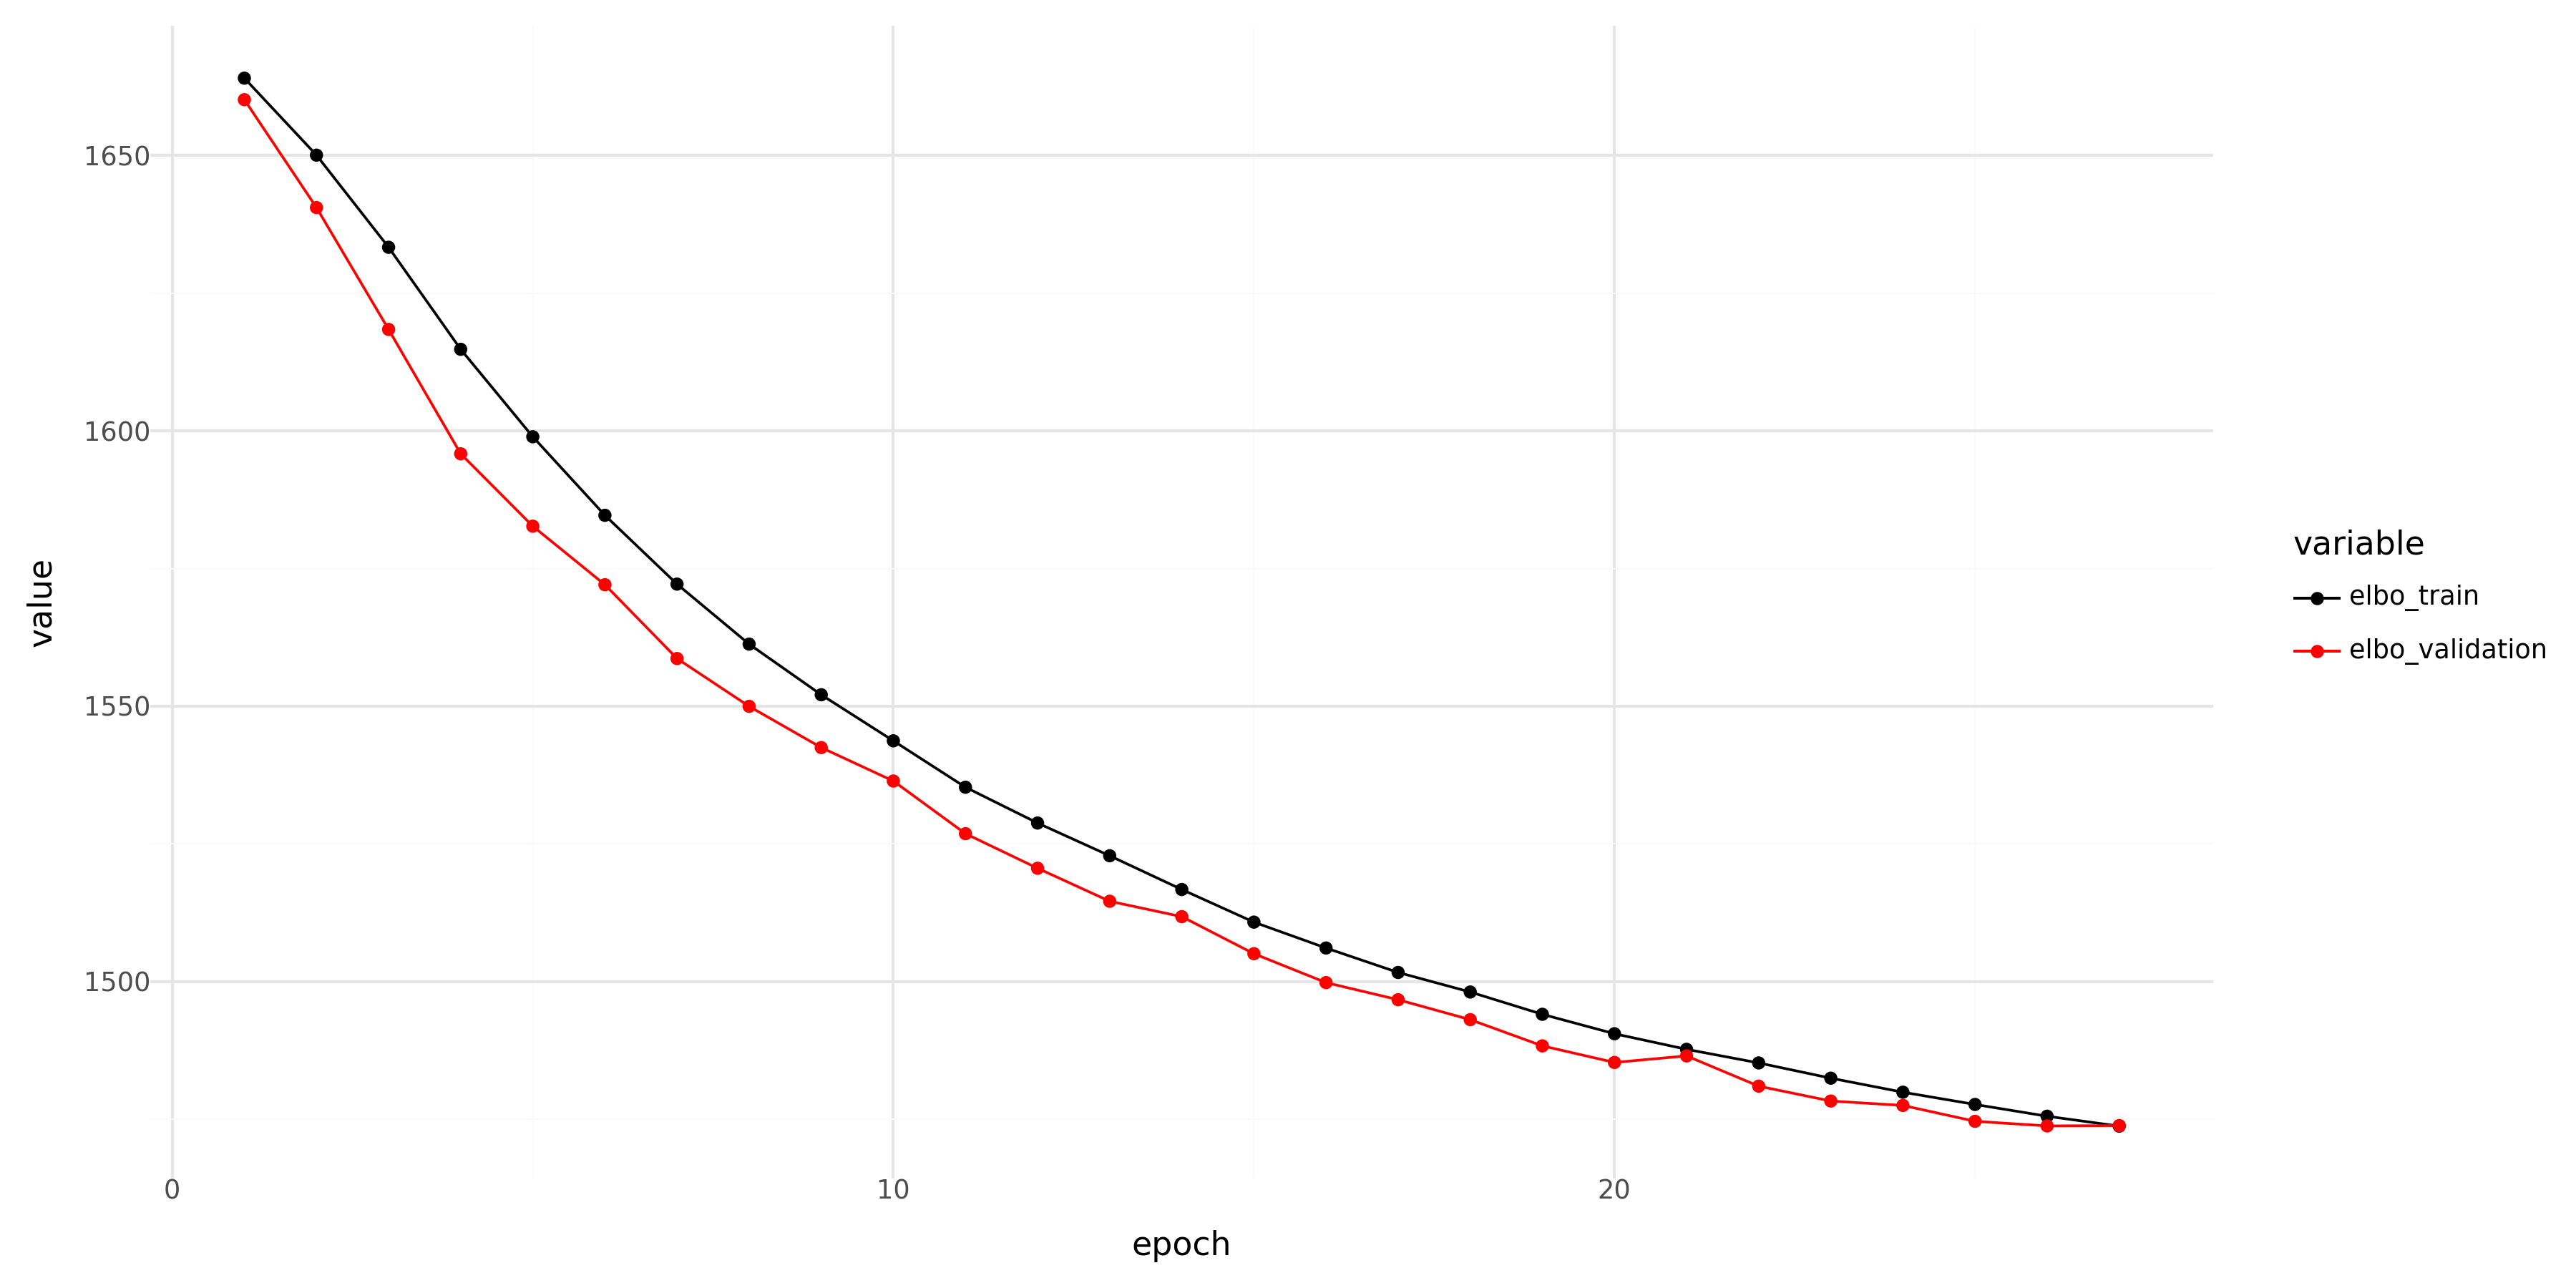

In [221]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

### Label transfer with `scANVI` 

In [222]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [223]:
scanvi_model.train(11, 
                   check_val_every_n_epoch = 1, 
                   enable_progress_bar = True,
                   accelerator = "gpu",
                   devices = [1]                            
)

INFO     Training for 11 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 11/11: 100%|██████████| 11/11 [00:56<00:00,  5.12s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.44e+3]

`Trainer.fit` stopped: `max_epochs=11` reached.


Epoch 11/11: 100%|██████████| 11/11 [00:56<00:00,  5.15s/it, v_num=1, train_loss_step=1.46e+3, train_loss_epoch=1.44e+3]


### Evaluate model performance a la Svensson

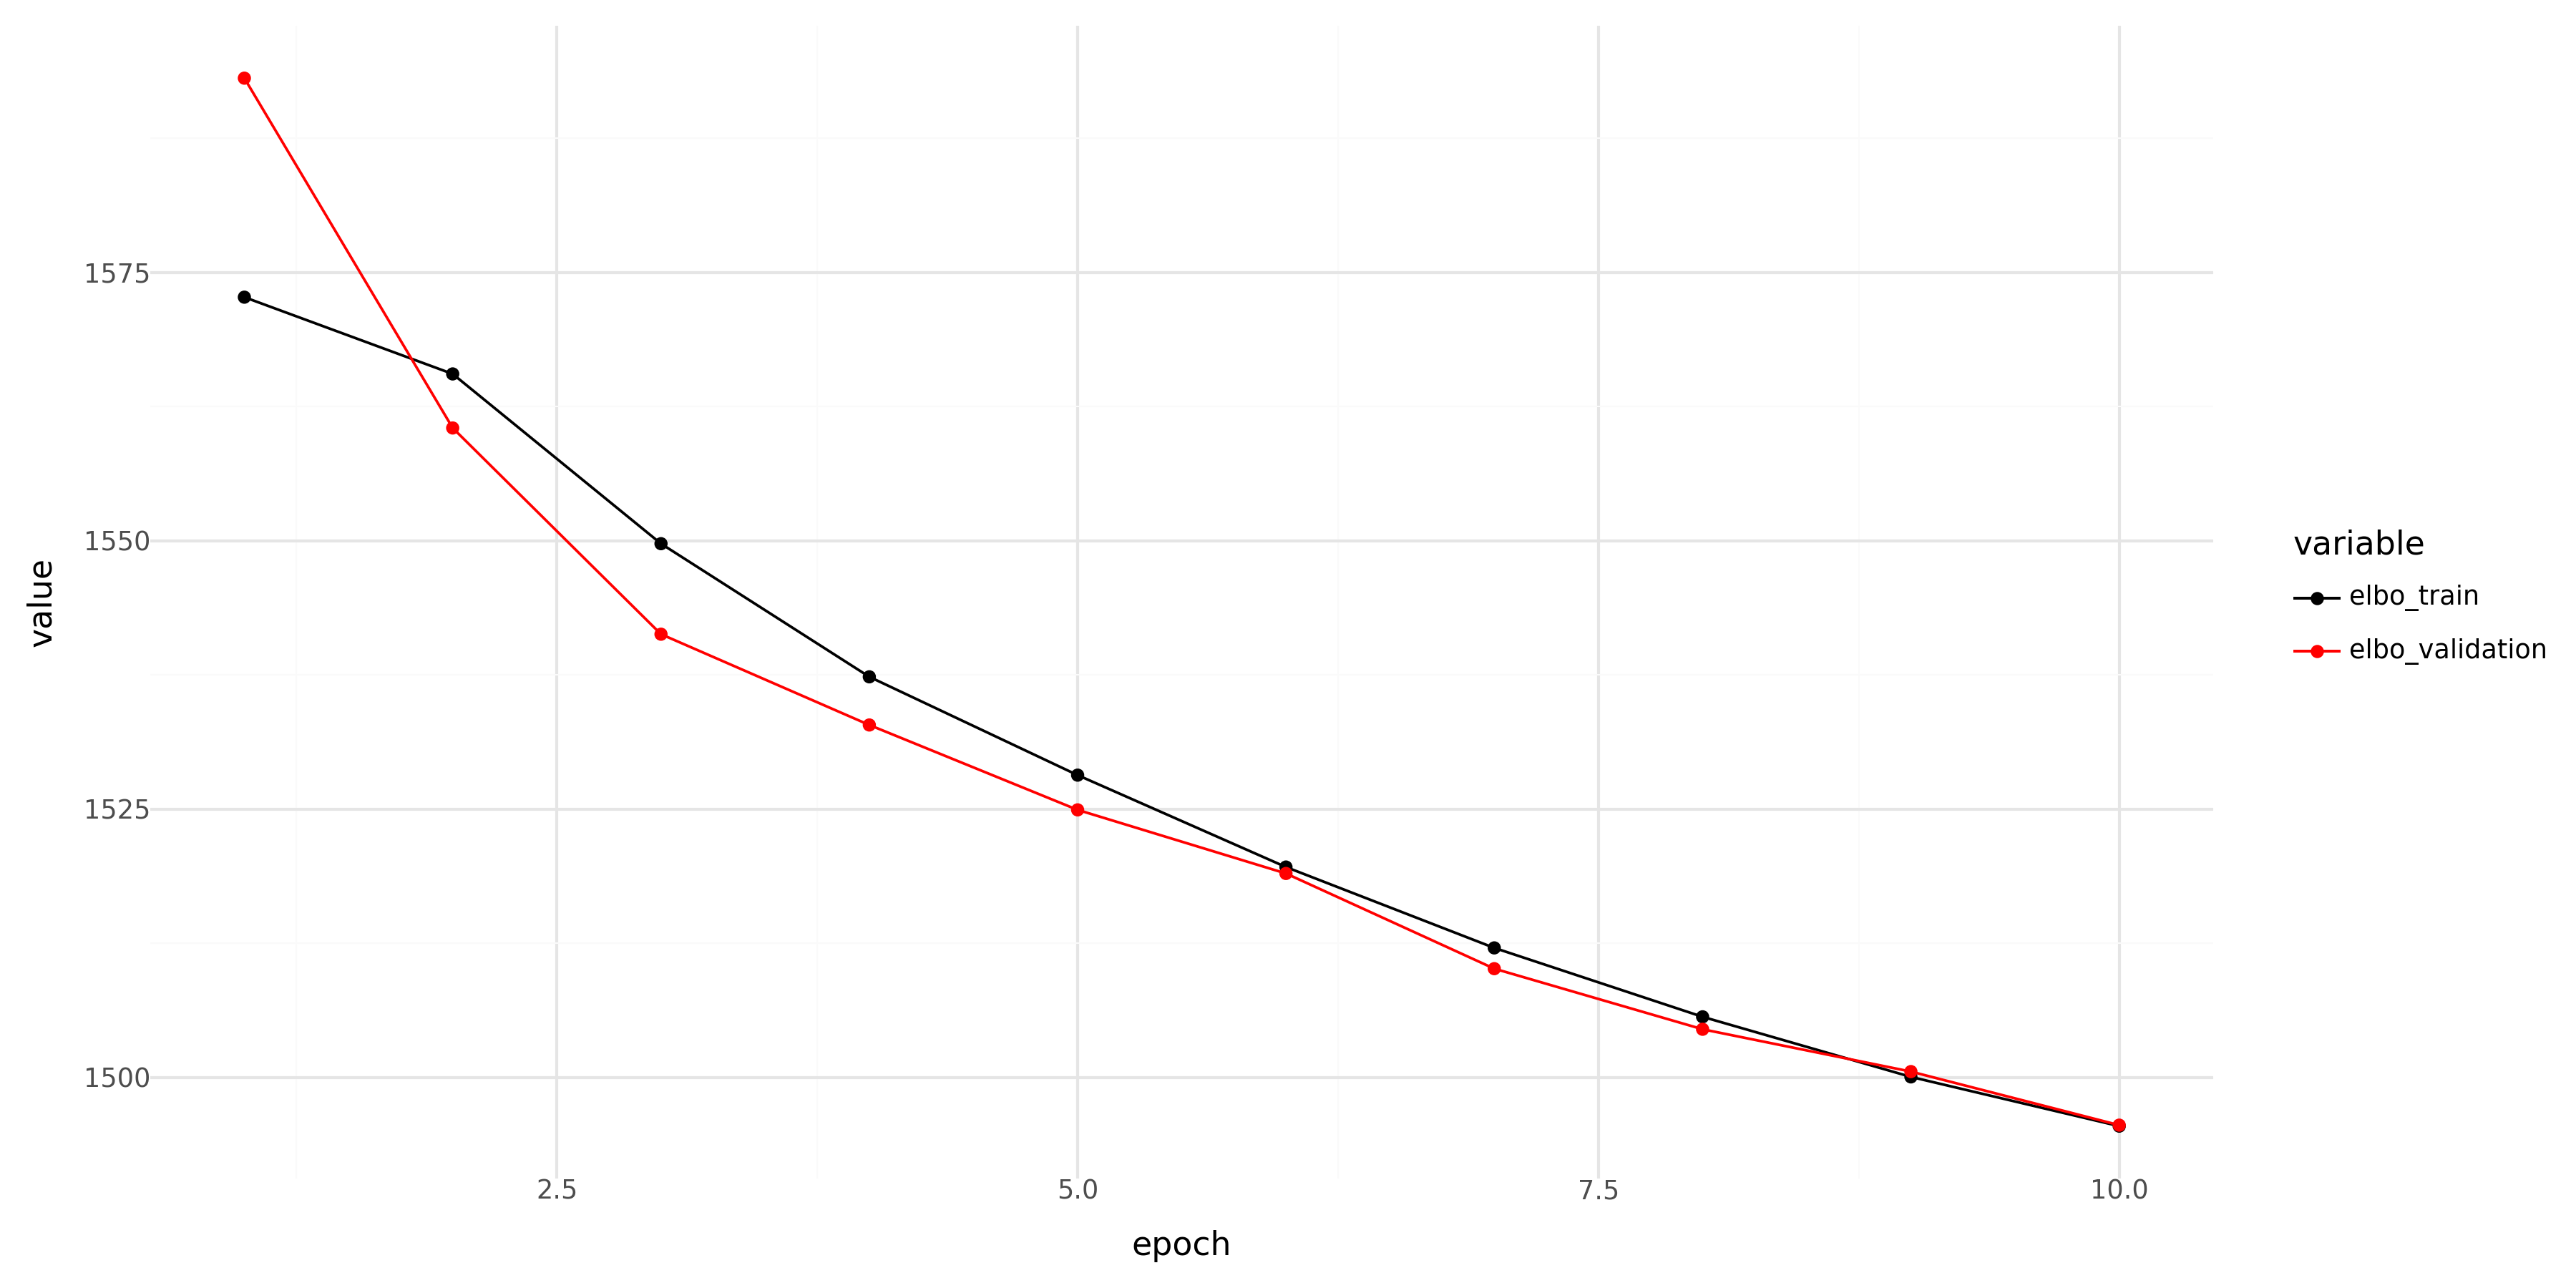

In [224]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig2.png', dpi = 300)

print(p_)

In [225]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [226]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

In [228]:
adata

AnnData object with n_obs × n_vars = 48696 × 7000
    obs: 'NRP', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'region', 'sample', 'scNym', 'scNym_confidence', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-A1-query', 'mean_counts-A1-query', 'pct_dropout_by_counts-A1-query', 'total_counts-A1-query', 'n_cells_by_counts-A2-query', 'mean_counts-A2-query', 'pct_dropout_by_counts-A2-query', 'total_counts-A2-query', 'n_cells_by_counts-A3-query', 'mean_counts-A3-query', 'pct_dropout_by_counts-A3-query', 'total_counts-A3-query', 'n_cells_by_counts-A4-query', 'mean_counts-A4-query', 'pct_dropout_by_coun

In [229]:
del(adata.obs['NRP'])
del(adata.obs['gender'])
del(adata.obs['scNym'])
del(adata.obs['scNym_confidence'])

In [231]:
adata.obs

,cell_source,cell_states,donor,n_counts,n_genes,region,sample,seed_labels,condition,genotype,...,pct_counts_ribo,percent_mt,percent_chrY,XIST-counts,S_score,G2M_score,batch,_scvi_batch,_scvi_labels,C_scANVI
AAAGTGAAGTCGGCCT-1-H0015_apex-reference,Harvard-Nuclei,CD4+T_cytox,H5,437.0,333,AX,H0015_apex,CD4+T,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,11,1,CD4+T
AAATGGAAGGTCCCTG-1-H0015_apex-reference,Harvard-Nuclei,CD4+T_cytox,H5,408.0,301,AX,H0015_apex,CD4+T,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,11,1,CD4+T
AAATGGAGTTGTCTAG-1-H0015_apex-reference,Harvard-Nuclei,doublets,H5,412.0,308,AX,H0015_apex,Doublets,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,11,4,NK
AACAACCGTAATTGGA-1-H0015_apex-reference,Harvard-Nuclei,DOCK4+MØ1,H5,476.0,368,AX,H0015_apex,Macrophages,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,11,5,Macrophages
AAGACTCTCAGGACGA-1-H0015_apex-reference,Harvard-Nuclei,Mast,H5,375.0,270,AX,H0015_apex,Mast_cells,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,reference,11,6,Mast_cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCACGCAGTC-1-B2-query,AG_Gerull,NaN,Ttn_Ctr_noninf_2,18844.0,4219,NaN,Ttn_Ctr_noninf_2,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,...,15.219699,0.036245,0.000000,0.0,-0.901389,-1.291862,query,19,11,Macrophages
TTTGGTTTCCTGTACC-1-B2-query,AG_Gerull,NaN,Ttn_Ctr_noninf_2,11805.0,3321,NaN,Ttn_Ctr_noninf_2,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,...,12.443880,0.022279,0.025413,1.0,-0.277671,-0.184796,query,19,11,Macrophages
TTTGTTGCAAGCTCTA-1-B2-query,AG_Gerull,NaN,Ttn_Ctr_noninf_1,3733.0,1849,NaN,Ttn_Ctr_noninf_1,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,...,5.062952,0.017412,0.000000,0.0,-0.179842,-0.495021,query,18,11,Macrophages
TTTGTTGTCCCAGGAC-1-B2-query,AG_Gerull,NaN,Ttn_Ctr_noninf_2,6388.0,2559,NaN,Ttn_Ctr_noninf_2,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,...,7.247965,0.023168,0.140889,0.0,0.080642,-0.877899,query,19,11,Macrophages


- Visualise corrected dataset

In [232]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:23)


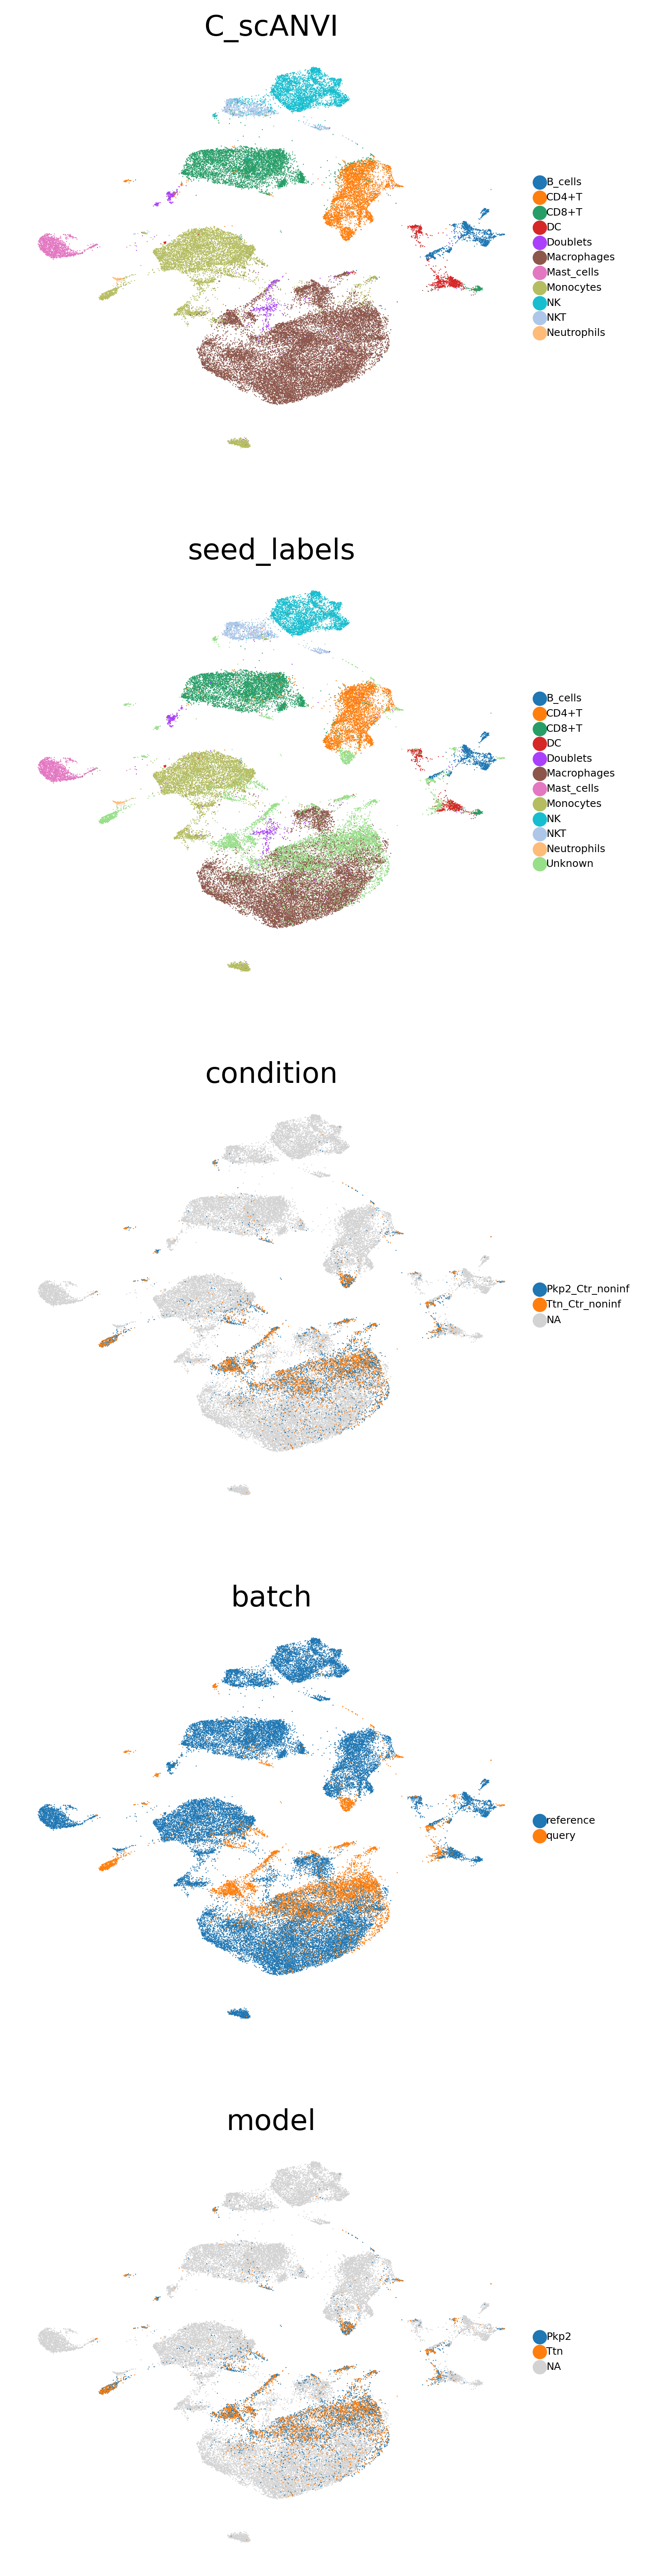

In [233]:
sc.pl.umap(adata, frameon = False, color = ['C_scANVI', 'seed_labels', 'condition', 'batch', 'model'], size = 1, legend_fontsize = 5, ncols = 1)

### Export annotated object

In [234]:
adata_export_merged = anndata.AnnData(X = adata_raw.X, var = adata_raw.var, obs = adata.obs)            #export a merged AnnData object with raw values from X and raw genes but modified observations
adata_export_merged

AnnData object with n_obs × n_vars = 48696 × 9438
    obs: 'cell_source', 'cell_states', 'donor', 'n_counts', 'n_genes', 'region', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-A1-query', 'mean_counts-A1-query', 'pct_dropout_by_counts-A1-query', 'total_counts-A1-query', 'n_cells_by_counts-A2-query', 'mean_counts-A2-query', 'pct_dropout_by_counts-A2-query', 'total_counts-A2-query', 'n_cells_by_counts-A3-query', 'mean_counts-A3-query', 'pct_dropout_by_counts-A3-query', 'total_counts-A3-query', 'n_cells_by_counts-A4-query', 'mean_counts-A4-query', 'pct_dropout_by_counts-A4-query', 'total_counts-A4-query', 'n_cell

In [235]:
adata_export = adata_export_merged[adata_export_merged.obs['batch'].isin(['query'])]                    #subset merged data set to keep only query
adata_export

View of AnnData object with n_obs × n_vars = 7847 × 9438
    obs: 'cell_source', 'cell_states', 'donor', 'n_counts', 'n_genes', 'region', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-A1-query', 'mean_counts-A1-query', 'pct_dropout_by_counts-A1-query', 'total_counts-A1-query', 'n_cells_by_counts-A2-query', 'mean_counts-A2-query', 'pct_dropout_by_counts-A2-query', 'total_counts-A2-query', 'n_cells_by_counts-A3-query', 'mean_counts-A3-query', 'pct_dropout_by_counts-A3-query', 'total_counts-A3-query', 'n_cells_by_counts-A4-query', 'mean_counts-A4-query', 'pct_dropout_by_counts-A4-query', 'total_counts-A4-query', 

### Add new gene symbols

In [236]:
query_export = anndata.AnnData(X = query.X, var = query.var, obs = adata_export.obs)                    #make sure to store the raw X values and the raw genes together with modified observations
query_export

AnnData object with n_obs × n_vars = 7847 × 32285
    obs: 'cell_source', 'cell_states', 'donor', 'n_counts', 'n_genes', 'region', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B

### Revert gene symbols

In [237]:
query_export.var_names = [gene_name.capitalize() for gene_name in query_export.var_names]           #restore mouse nomenclature
query_export.var_names

Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'Lypla1',
       ...
       'Gm16367', 'Ac163611.1', 'Ac163611.2', 'Ac140365.1', 'Ac124606.2',
       'Ac124606.1', 'Ac133095.2', 'Ac133095.1', 'Ac234645.1', 'Ac149090.1'],
      dtype='object', length=32285)

In [238]:
query_export.obs['C_scANVI'].value_counts()

C_scANVI
Macrophages    5135
Monocytes      1217
CD4+T           549
B_cells         272
Doublets        213
DC              181
CD8+T           146
NKT              58
NK               50
Neutrophils      15
Mast_cells       11
Name: count, dtype: int64

In [239]:
query_export

AnnData object with n_obs × n_vars = 7847 × 32285
    obs: 'cell_source', 'cell_states', 'donor', 'n_counts', 'n_genes', 'region', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts-A1', 'mean_counts-A1', 'pct_dropout_by_counts-A1', 'total_counts-A1', 'n_cells_by_counts-A2', 'mean_counts-A2', 'pct_dropout_by_counts-A2', 'total_counts-A2', 'n_cells_by_counts-A3', 'mean_counts-A3', 'pct_dropout_by_counts-A3', 'total_counts-A3', 'n_cells_by_counts-A4', 'mean_counts-A4', 'pct_dropout_by_counts-A4', 'total_counts-A4', 'n_cells_by_counts-B1', 'mean_counts-B1', 'pct_dropout_by_counts-B1', 'total_counts-B1', 'n_cells_by_counts-B2', 'mean_counts-B

In [240]:
#Clean up metadata - delete all columns that came from merging with reference data set

del(query_export.obs['cell_states'])
del(query_export.obs['region'])

In [241]:
query_export.obs

,cell_source,donor,n_counts,n_genes,sample,seed_labels,condition,genotype,infection,library,...,pct_counts_ribo,percent_mt,percent_chrY,XIST-counts,S_score,G2M_score,batch,_scvi_batch,_scvi_labels,C_scANVI
AAACCCAAGATACAGT-1-A1-query,AG_Gerull,Pkp2_Ctr_noninf_2,8562.0,2769,Pkp2_Ctr_noninf_2,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,23.662696,0.019038,0.000000,0.0,-0.339369,-0.496060,query,15,11,CD4+T
AAACGCTGTTGTGTTG-1-A1-query,AG_Gerull,Pkp2_Ctr_noninf_1,750.0,365,Pkp2_Ctr_noninf_1,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,4.533333,0.346667,0.000000,0.0,-0.019995,-0.083225,query,14,11,Doublets
AAACGCTTCTCGCTCA-1-A1-query,AG_Gerull,Pkp2_Ctr_noninf_1,3855.0,1599,Pkp2_Ctr_noninf_1,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,1.815824,0.043320,0.025940,0.0,-0.169221,-0.390143,query,14,11,Monocytes
AAAGGTACAGAACATA-1-A1-query,AG_Gerull,Pkp2_Ctr_noninf_2,17536.0,3854,Pkp2_Ctr_noninf_2,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,10.213276,0.027315,0.051323,0.0,-0.317632,-0.578954,query,15,11,Monocytes
AAAGTCCAGGGACACT-1-A1-query,AG_Gerull,Pkp2_Ctr_noninf_2,14174.0,3788,Pkp2_Ctr_noninf_2,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,...,14.456046,0.023282,0.014110,0.0,-0.370103,-0.370084,query,15,11,Macrophages
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTCACGCAGTC-1-B2-query,AG_Gerull,Ttn_Ctr_noninf_2,18844.0,4219,Ttn_Ctr_noninf_2,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,15.219699,0.036245,0.000000,0.0,-0.901389,-1.291862,query,19,11,Macrophages
TTTGGTTTCCTGTACC-1-B2-query,AG_Gerull,Ttn_Ctr_noninf_2,11805.0,3321,Ttn_Ctr_noninf_2,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,12.443880,0.022279,0.025413,1.0,-0.277671,-0.184796,query,19,11,Macrophages
TTTGTTGCAAGCTCTA-1-B2-query,AG_Gerull,Ttn_Ctr_noninf_1,3733.0,1849,Ttn_Ctr_noninf_1,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,5.062952,0.017412,0.000000,0.0,-0.179842,-0.495021,query,18,11,Macrophages
TTTGTTGTCCCAGGAC-1-B2-query,AG_Gerull,Ttn_Ctr_noninf_2,6388.0,2559,Ttn_Ctr_noninf_2,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,...,7.247965,0.023168,0.140889,0.0,0.080642,-0.877899,query,19,11,Macrophages


In [242]:
query_export.write('/home/acirnu/data/ACM_cardiac_leuco/scANVI/Pkp2+Ttn_Ctrls_scANVI_cellstates_from_HCA_15000HVGs_ac240308.raw.h5ad')   

In [243]:
pd.crosstab(query_export.obs['C_scANVI'], query_export.obs['condition'])

condition,Pkp2_Ctr_noninf,Ttn_Ctr_noninf
C_scANVI,,
B_cells,154,118
CD4+T,342,207
CD8+T,98,48
DC,105,76
Doublets,127,86
Macrophages,2790,2345
Mast_cells,4,7
Monocytes,776,441
NK,34,16
